In [21]:
import pandas as pd
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


df = pd.read_csv('./lan_detection_data.csv') 
print(df['Language'].value_counts())

df = pd.read_csv('./lan_detection_data_final.csv') 
df_train = df[0:500000]
df_train = df_train.reset_index(drop=True)
df_validation = df.loc[500000:505000]
df_validation = df_validation.reset_index(drop=True)
df_test = df.loc[510000:520000]
df_test = df_test.reset_index(drop=True)
# df.shape
# df_validation.shape
print(df_train['Language'].value_counts())
print(df_validation['Language'].value_counts())
print(df_test['Language'].value_counts())




eng    250102
spa    249898
Name: Language, dtype: int64
eng    2530
spa    2471
Name: Language, dtype: int64
eng    5037
spa    4964
Name: Language, dtype: int64


In [2]:
from nltk.tokenize import regexp_tokenize
import numpy as np
import pickle

# Here is a default pattern for tokenization, you can substitue it with yours
default_pattern =  r"""(?x)                  
                        (?:[A-Z]\.)+          
                        |\$?\d+(?:\.\d+)?%?    
                        |\w+(?:[-']\w+)*      
                        |\.\.\.               
                        |(?:[.,;"'?():-_`])    
                    """

def tokenize(text, pattern = default_pattern):
    """Tokenize senten with specific pattern
    
    Arguments:
        text {str} -- sentence to be tokenized, such as "I love NLP"
    
    Keyword Arguments:
        pattern {str} -- reg-expression pattern for tokenizer (default: {default_pattern})
    
    Returns:
        list -- list of tokenized words, such as ['I', 'love', 'nlp']
    """
    text = str(text)
    text = text.lower()
    return str(regexp_tokenize(text, pattern))


class FeatureExtractor(object):
    """Base class for feature extraction.
    """
    def __init__(self):
        pass
    def fit(self, text_set):
        pass
    def transform(self, text):
        pass  
    def transform_list(self, text_set):
        pass




class UnigramFeature(FeatureExtractor):
    """Example code for unigram feature extraction
    """
    def __init__(self):
        # dictionary that maps unigrams into their indexes by order of appearance
        self.unigram = {}
        
    def fit(self, text_set: list):
        """Fit a feature extractor based on given data 
        
        Arguments:
            text_set {list} -- list of tokenized sentences and words are lowercased, such as [["I", "love", "nlp"], ["I", "like", "python"]]
        """
        index = 0
        for i in range(0, len(text_set)):
            for j in range(0, len(text_set[i])):
                if text_set[i][j].lower() not in self.unigram:
                    self.unigram[text_set[i][j].lower()] = index
                    index += 1
                else:
                    continue
                    
    def transform(self, text: list):
        """Transform a given sentence into vectors based on the extractor you got from self.fit()
        
        Arguments:
            text {list} -- a tokenized sentence (list of words), such as ["I", "love", "nlp"]
        
        Returns:
            array -- an unigram feature array, such as array([1,1,1,0,0,0])
        """
        # Feature has the size of the number of distinct words received
        feature = np.zeros(len(self.unigram))
        # We go through every word in the text
        for i in range(0, len(text)):
            if text[i].lower() in self.unigram:
                # If it contained in the unigram,
                # It is a feature of the new text.
                # We search for the index of the word in the text and use that index in the feature as well
                # Then, we increase the number of occurrences of that word.
                # Seems like the bag of words seen in class.
                feature[self.unigram[text[i].lower()]] += 1
        
        return feature.tolist()
    
    
    def transform_list(self, text_set: list):
        """Transform a list of tokenized sentences into vectors based on the extractor you got from self.fit()
        
        Arguments:
            text_set {list} --a list of tokenized sentences, such as [["I", "love", "nlp"], ["I", "like", "python"]]
        
        Returns:
            array -- unigram feature arraies, such as array([[1,1,1,0,0], [1,0,0,1,1]])
        """
        # Same as previous method but at sentences level
        features = []
        for i in range(0, len(text_set)):
            features.append(self.transform(text_set[i]))
        
        
        
        return np.array(features)

    def indexesToWords(self, words):
        for word, index in self.unigram.items():
            if index in words:
                print(word)
    
    def save(self):
        """save class as self.name.txt"""
        file = open('feature_extractor.txt','wb')
        file.write(pickle.dumps(self.__dict__))
        file.close()

    def load(self):
        """try load self.name.txt"""
        file = open('feature_extractor.txt','rb')
        dataPickle = file.read()
        file.close()

        self.__dict__ = pickle.loads(dataPickle)
        

In [3]:

tokens = []
labels = []
lan_to_label = {'eng':0,'spa':1}
feature_extractor = UnigramFeature()


# training data
for row in df.index:
    tokens.append(tokenize(df.loc[row]['Text']))
    labels.append(lan_to_label[df.loc[row]['Language']])

df['tokens'] = tokens
df['labels'] = labels

feature_extractor.fit(tokens)
feature_extractor.save()

feature_extractor.load()

vectors = feature_extractor.transform_list(tokens)
vectors = vectors.tolist()



len(vectors)
vectors = pd.Series(vectors)
df['vectors'] = vectors

# validation and test data
tokens = []
labels = []
for row in df_validation.index:
    tokens.append(tokenize(df_validation.loc[row]['Text']))
    labels.append(lan_to_label[df_validation.loc[row]['Language']])

df_validation['tokens'] = tokens
df_validation['labels'] = labels
vectors = feature_extractor.transform_list(tokens)
vectors = vectors.tolist()
vectors = pd.Series(vectors)
df_validation['vectors'] = vectors

tokens = []
labels = []
for row in df_test.index:
    tokens.append(tokenize(df_test.loc[row]['Text']))
    labels.append(lan_to_label[df_test.loc[row]['Language']])

df_test['tokens'] = tokens
df_test['labels'] = labels
vectors = feature_extractor.transform_list(tokens)
vectors = vectors.tolist()
vectors = pd.Series(vectors)
df_test['vectors'] = vectors


print(df_validation)
print(df_test)



      Unnamed: 0  Unnamed: 0.1 Language  \
0         250633       6076601      eng   
1        1053850       3255881      eng   
2        1827548       7376708      eng   
3        1900417       5567566      spa   
4          30628       9080415      eng   
...          ...           ...      ...   
4996      652007        275002      eng   
4997      804386       2888176      spa   
4998     1039379       6231485      eng   
4999       64252        864357      spa   
5000     1378543       1853480      eng   

                                                   Text  \
0                   Is anybody here willing to do that?   
1     If it's a simple piece of music, I can sight-s...   
2                  Mary is blind in one eye, isn't she?   
3     Uno de mis favoritos cuentos de hadas cuando e...   
4                                Let's go to the party!   
...                                                 ...   
4996                     He that talks much, errs much.   
4997       

In [13]:
print(feature_extractor.unigram)

{'[': 0, "'": 1, 'h': 2, 'i': 3, 's': 4, ',': 5, ' ': 6, 'p': 7, 'e': 8, 'c': 9, 'a': 10, 'd': 11, 'n': 12, 'f': 13, 't': 14, 'o': 15, 'u': 16, 'r': 17, 'm': 18, '.': 19, ']': 20, 'y': 21, 'k': 22, 'w': 23, '"': 24, 'l': 25, 'x': 26, 'g': 27, 'v': 28, 'b': 29, 'z': 30, '?': 31, 'q': 32, 'ó': 33, 'j': 34, 'á': 35, 'é': 36, '6': 37, 'í': 38, '1': 39, '9': 40, '7': 41, '4': 42, '8': 43, 'ú': 44, '2': 45, '0': 46, '-': 47, '3': 48, 'ñ': 49, ':': 50, 'æ': 51, ';': 52, '(': 53, ')': 54, '%': 55, '5': 56, 'ü': 57, '$': 58, 'ṛ': 59, 'ḥ': 60, 'ɣ': 61, 'ṭ': 62, 'ø': 63, 'ẓ': 64, 'ḍ': 65, 'ö': 66, 'ɛ': 67, 'ē': 68, 'ǧ': 69, 'è': 70, '이': 71, '것': 72, '은': 73, '사': 74, '전': 75, '다': 76, '그': 77, '건': 78, '내': 79, '야': 80, 'ë': 81, '누': 82, '구': 83, '입': 84, '니': 85, '까': 86, '비': 87, '싸': 88, '면': 89, '될': 90, '요': 91, '는': 92, '을': 93, '용': 94, '했': 95, '나': 96, '에': 97, '게': 98, '있': 99, 'त': 100, 'ल': 101, 'आ': 102, 'व': 103, 'ड': 104, 'स': 105, 'म': 106, 'ह': 107, 'à': 108, '당': 109, '신': 110,

In [4]:
import torch

x_train = torch.tensor(df['vectors'])
y_train = torch.tensor(df['labels'],dtype=torch.float32)

x_validation = torch.tensor(df_validation['vectors'])
y_validation = torch.tensor(df_validation['labels'],dtype=torch.float32)

x_test = torch.tensor(df_test['vectors'])
y_test = torch.tensor(df_test['labels'],dtype=torch.float32)

print(x_train.dtype)
print(y_train.dtype)
print(len(x_train),len(y_train))
print(len(x_validation),len(y_validation))
print(len(x_test),len(y_test))

torch.float32
torch.float32
500001 500001
5001 5001
10001 10001


In [5]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
validation_ds = TensorDataset(x_validation, y_validation)
test_ds = TensorDataset(x_test, y_test)


In [6]:
from torch.utils.data import DataLoader
batch_size = 16
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
validation_dl = DataLoader(validation_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)


In [7]:
import torch
import torch.nn as nn


class ClassificationModel(nn.Module):
    
    def __init__(self, vocab_size,embedding_dim, hidden_dim):
        super().__init__()
        print(vocab_size)
        self.embedded_layer = nn.Embedding(vocab_size,embedding_dim=embedding_dim)
        self.fc1 = torch.nn.Linear(vocab_size, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim,32)
        self.fc3 = torch.nn.Linear(32,1)
        self.sigmoid = torch.nn.Sigmoid()
        

    def forward(self, x):
        
        x = self.fc1(x)        
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        output = self.sigmoid(x)
        
        return output

In [8]:
hidden_dimension = 64
embedding_dimension = 300
print(x_train)
vocab_dimension = len(x_train[0])
model = ClassificationModel(vocab_dimension, embedding_dimension, hidden_dimension)

tensor([[ 1., 18.,  3.,  ...,  0.,  0.,  0.],
        [ 1., 31.,  4.,  ...,  0.,  0.,  0.],
        [ 1., 15.,  2.,  ...,  0.,  0.,  0.],
        ...,
        [ 1., 12.,  1.,  ...,  0.,  0.,  0.],
        [ 1., 22.,  2.,  ...,  0.,  0.,  0.],
        [ 1., 22.,  2.,  ...,  0.,  0.,  0.]])
220


In [9]:
import torch.nn.functional as F
learning_rate = 0.0001
loss_fn = torch.nn.BCELoss()
opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
# Utility function to train the model
from sklearn.metrics import f1_score, accuracy_score
import tqdm
def train(model, loss_fn, opt, train_dl):
    model.train()
    true, preds = [], []
    total_loss = 0
    # Repeat for given number of epochs

        
    # Train with batches of data
    for xb,yb in tqdm.tqdm(train_dl):
        
        # 1. Generate predictions
        pred = model(xb)
        
        
        
        # 2. Calculate loss
        
        pred = torch.squeeze(pred)
        yb = torch.squeeze(yb)
        loss = loss_fn(pred, yb)
        total_loss += loss.item()



        # # saving the results
        # for i_batch in range(len(yb)):
        #     true.append(yb[i_batch].item())
        #     preds.append(round(pred[i_batch].item()))
        
        # 3. Compute gradients
        loss.backward()
        
        # 4. Update parameters using gradients
        opt.step()
        
        # 5. Reset the gradients to zero
        opt.zero_grad()

    # Print the progress
    return total_loss

In [11]:
# Utility function to train the model
def test(model, loss_fn, validation_dl):
    true, preds = [], []
    total_loss = 0
    # Train with batches of data
    for xb,yb in tqdm.tqdm(validation_dl):
        
        # 1. Generate predictions
        pred = model(xb)

        # saving the results
        # for i_batch in range(len(yb)):
        #     true.append(yb[i_batch].item())
        #     preds.append(round(pred[i_batch].item()))
       
        pred = torch.squeeze(pred)
        yb = torch.squeeze(yb)
        
        # 2. Calculate loss
        loss = loss_fn(pred, yb)
        total_loss += loss.item()
    return true, preds, total_loss



In [12]:
train_store = []
validation_store = []
acc_train_store = []
acc_val_store = []
f1_train_store = []
f1_val_store = []
TOTAL_EPOCHS = 10
for epoch in range(TOTAL_EPOCHS):
    train_loss = train(model, loss_fn, opt,train_dl)
    v_true, v_pred, val_loss = test(model,loss_fn, validation_dl)
    train_store.append(train_loss)

    # validation_store.append(val_loss)
    print(f"EPOCH: {epoch}")
    """
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VALIDATION LOSS: {val_loss}")

    acc_val = accuracy_score(v_true, v_pred)
    f1_val = f1_score(v_true, v_pred, average='weighted')
    # acc_train = accuracy_score(t_true, t_pred)
    # f1_train = f1_score(t_true, t_pred, average='weighted')

    acc_val_store.append(acc_val)
    f1_val_store.append(f1_val)
    # acc_train_store.append(acc_train)
    # f1_train_store.append(f1_train)

    print(f"VAL F-1: {f1_val}")
    print(f"VAL ACC: {acc_val}")
    """

100%|██████████| 31251/31251 [00:10<00:00, 2888.64it/s]


EPOCH: 0


100%|██████████| 31251/31251 [00:10<00:00, 2862.49it/s]


EPOCH: 1


 38%|███▊      | 11907/31251 [00:08<00:13, 1428.69it/s]


KeyboardInterrupt: 

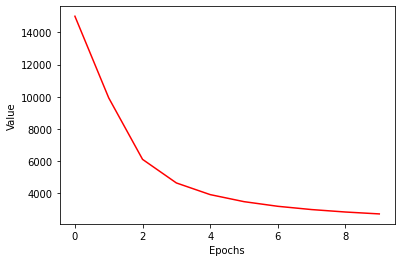

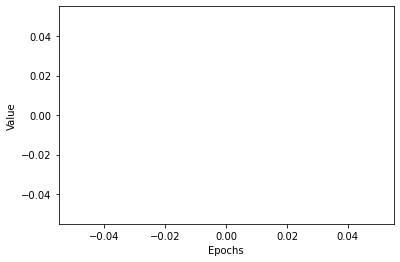

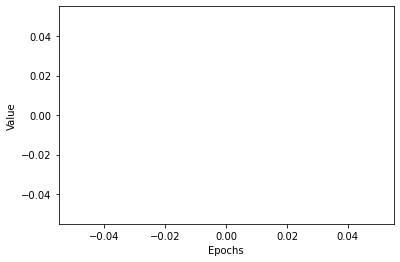

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_store, c="red", label ="train")
plt.plot(validation_store, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.show()

# plt.plot(acc_train_store, c="red", label ="train")
plt.plot(acc_val_store, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.show()

# plt.plot(f1_train_store, c="red", label ="train")
plt.plot(f1_val_store, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.show()

In [ ]:

true, pred, val_loss = test(model,loss_fn, test_dl)
print(f"VAL F-1: {f1_score(true, pred, average='weighted')}")
print(f"VAL ACC: {accuracy_score(true, pred)}")

 59%|█████▉    | 18555/31251 [00:09<00:06, 1953.24it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), './model_file')

In [ ]:
from nltk.tokenize import regexp_tokenize
import numpy as np
import pickle
import torch

# Here is a default pattern for tokenization, you can substitue it with yours
default_pattern =  r"""(?x)                  
                        (?:[A-Z]\.)+          
                        |\$?\d+(?:\.\d+)?%?    
                        |\w+(?:[-']\w+)*      
                        |\.\.\.               
                        |(?:[.,;"'?():-_`])    
                    """

def tokenize(text, pattern = default_pattern):
    """Tokenize senten with specific pattern
    
    Arguments:
        text {str} -- sentence to be tokenized, such as "I love NLP"
    
    Keyword Arguments:
        pattern {str} -- reg-expression pattern for tokenizer (default: {default_pattern})
    
    Returns:
        list -- list of tokenized words, such as ['I', 'love', 'nlp']
    """
    text = str(text)
    text = text.lower()
    return str(regexp_tokenize(text, pattern))


class FeatureExtractor(object):
    """Base class for feature extraction.
    """
    def __init__(self):
        pass
    def fit(self, text_set):
        pass
    def transform(self, text):
        pass  
    def transform_list(self, text_set):
        pass




class UnigramFeature(FeatureExtractor):
    """Example code for unigram feature extraction
    """
    def __init__(self):
        # dictionary that maps unigrams into their indexes by order of appearance
        self.unigram = {}
        
    def fit(self, text_set: list):
        """Fit a feature extractor based on given data 
        
        Arguments:
            text_set {list} -- list of tokenized sentences and words are lowercased, such as [["I", "love", "nlp"], ["I", "like", "python"]]
        """
        index = 0
        for i in range(0, len(text_set)):
            for j in range(0, len(text_set[i])):
                if text_set[i][j].lower() not in self.unigram:
                    self.unigram[text_set[i][j].lower()] = index
                    index += 1
                else:
                    continue
                    
    def transform(self, text: list):
        """Transform a given sentence into vectors based on the extractor you got from self.fit()
        
        Arguments:
            text {list} -- a tokenized sentence (list of words), such as ["I", "love", "nlp"]
        
        Returns:
            array -- an unigram feature array, such as array([1,1,1,0,0,0])
        """
        # Feature has the size of the number of distinct words received
        feature = np.zeros(len(self.unigram))
        # We go through every word in the text
        for i in range(0, len(text)):
            if text[i].lower() in self.unigram:
                # If it contained in the unigram,
                # It is a feature of the new text.
                # We search for the index of the word in the text and use that index in the feature as well
                # Then, we increase the number of occurrences of that word.
                # Seems like the bag of words seen in class.
                feature[self.unigram[text[i].lower()]] += 1
        
        return feature.tolist()
    
    
    def transform_list(self, text_set: list):
        """Transform a list of tokenized sentences into vectors based on the extractor you got from self.fit()
        
        Arguments:
            text_set {list} --a list of tokenized sentences, such as [["I", "love", "nlp"], ["I", "like", "python"]]
        
        Returns:
            array -- unigram feature arraies, such as array([[1,1,1,0,0], [1,0,0,1,1]])
        """
        # Same as previous method but at sentences level
        features = []
        for i in range(0, len(text_set)):
            features.append(self.transform(text_set[i]))
        
        
        
        return np.array(features)

    def indexesToWords(self, words):
        for word, index in self.unigram.items():
            if index in words:
                print(word)
    
    def save(self):
        """save class as self.name.txt"""
        file = open('feature_extractor.txt','wb')
        file.write(pickle.dumps(self.__dict__))
        file.close()

    def load(self):
        """try load self.name.txt"""
        file = open('feature_extractor.txt','rb')
        dataPickle = file.read()
        file.close()

        self.__dict__ = pickle.loads(dataPickle)
        

In [ ]:
feature_extractor = UnigramFeature()
feature_extractor.load()

query = "Cuál es el mejor restaurante de Nueva York?"
query = tokenize(query)
print(query)

query = feature_extractor.transform(query)
query = torch.tensor(query)

['cuál', 'es', 'el', 'mejor', 'restaurante', 'de', 'nueva', 'york', '?']


In [ ]:
import torch
import torch.nn as nn


class ClassificationModel(nn.Module):
    
    def __init__(self, vocab_size, hidden_dim):
        super().__init__()
        print(vocab_size)
        self.embedded_layer = nn.Embedding(vocab_size,embedding_dim=embedding_dim)
        self.fc1 = torch.nn.Linear(vocab_size, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim,32)
        self.fc3 = torch.nn.Linear(32,1)
        self.sigmoid = torch.nn.Sigmoid()
        

    def forward(self, x):
        
        x = self.fc1(x)        
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        output = self.sigmoid(x)
                
        return output
model = ClassificationModel(len(query),64)
model.load_state_dict(torch.load('./model_file'))


220


<All keys matched successfully>

In [ ]:
def predict(model, query):
    model.zero_grad()    
    result = model(query)
    result = round(result.item())
    if result == 0:
        print('en')
    else:
        print('es')


predict(model,query)

es
